Created: 01/12/2020
Author: Ryan Corbyn 

Edited: Date, Name 


This code is designed to plot the mean lock-in amplification ODMR line scan data. 
From here, a curve-fit is applied to the data and the parameters of the curve fit are saved in the same folder location as the lock-in data. 


In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plot
import os 
import scipy.optimize as opt

In [4]:
def get_data(file_location):
    # Gets the data from the folder location and saves it to a pandas 
    # Data frame. 
    
    data = pd.read_table(file_location)
    return(data)

In [5]:
def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 20})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

In [6]:
def normalise_data(mean_odmr_data):
    # normalise the data to the maximum value of the mean dataset. 
    norm_odmr_data = mean_odmr_data/(np.mean(mean_odmr_data[0:50]))
    return(norm_odmr_data)

In [7]:
def scatter_plot(freq, mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    ax2.set_xlim(np.min(freq),np.max(freq))
    return(fig2, ax2)

In [8]:
def get_init_params(odmr_data, freq):
    # find the minima of the ODMR spectra and ODMR dip contrast and 
    # flourenscent baseline.
    half_data_length = int((len(freq)-1)/2)
    
    #find the indices for the lowest frequency value
    low_freq_min_index = np.where(odmr_data[0:half_data_length] == np.min(odmr_data[0:half_data_length]))
    high_freq_min_index = np.where(odmr_data[half_data_length:len(odmr_data)-1] == 
                                   np.min(odmr_data[half_data_length:len(odmr_data)-1]))
   
    # frequencies corresponding to ODMR minima
    freq_mins = [np.float(freq[low_freq_min_index[0]]),
                 np.float(freq[high_freq_min_index[0]+half_data_length])]
    
    # manually set frequencies. 
    
    #freq_mins = [2.78, 2.96]
    
    flourescent_baseline = np.mean(odmr_data)
    
    # approximate contrast for ODMR peaks
    contrast = [np.float((1-odmr_data[low_freq_min_index[0]]/flourescent_baseline)), 
                np.float((1-odmr_data[high_freq_min_index[0]+half_data_length]/flourescent_baseline))]

    return(freq_mins, contrast, flourescent_baseline)

In [17]:
def optimised_lorentz_fit(freq, mean_data, init_params):
    # A method to find the fitting prameters for the ODMR dataset. 
    y_error = np.sqrt(mean_data) # poissonian noise
    try:
        coeffs, confidence = opt.curve_fit(quad_lorentz, freq, mean_data, init_params, sigma = y_error)
        opt_error = np.sqrt(np.diag(confidence))
    except:
        coeffs = []
        opt_error = []
        for i in range(len(init_params)):
            coeffs.append(0)
            opt_error.append(0)
    
    return(coeffs, opt_error)

In [10]:
def quad_lorentz(x, A1, X01, sig1, A2, X02, sig2, A3, X03, sig3, A4, X04, sig4, offset): 
    #P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # A1 = Amplitude 1, X01 = Resonance 1, sig1 = FWHM 1
    # A2 = Amplitude 2, X02 = Resonance 2, sig2 = FWHM 2, offset = offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    third_peak = (A3/np.pi)*((sig3**2)/(sig3**2 +(2*x-2*X03)**2))
    forth_peak = (A4/np.pi)*((sig4**2)/(sig4**2 +(2*x-2*X04)**2))

    return (first_peak + second_peak + third_peak + forth_peak + offset)

In [11]:
def plot_fitting(ax2, freq, y_fit):
    # plot the y fit. 
    
    ax2.plot(freq, y_fit, color='k', label='Double Lorentz \nfitting')
    ax2.legend()
    ax2.set_xlabel('Microwave Frequency (GHz)', fontsize = 18)
    ax2.set_ylabel('Normalised Counts', fontsize = 18)
    
    return(ax2)

In [12]:
def get_r_squared(x, y_data, y_fitting):
    # This is a function used to generate the goodness of fit metric r^2.
    # This value will be used to judge the effectiveness of the curve fitting 
    # used to find the resonant frequencies of the NV centre.
    
    y_data_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_data_mean)**2) # Find the variation in experimental y values.
    SSres = np.sum((y_data - y_fitting)**2) # Find the variation betweem the experimental and fitted y values. 
    
    r_squared = 1 - (SSres/SStot) # Calculate R^2
    
    return(r_squared)

In [1]:
def get_chi_squared(y_data, y_fit):
    # calculate the chi squared value for the goodness of 
    # fit for the Lorentz curve. 
    
    chi_squared_array = []
    for i in range(len(y_data)):
        chi_squared_array.append(np.power(y_data[i]-y_fit[i],2)/y_fit[i])
    
    chi_squared = np.sum(chi_squared_array)
    print(chi_squared)
    return(chi_squared)

In [2]:
def get_RMS_error(y_data, y_fit):
    # Calculate the RMS error for the fitting vs the actual ODMR data (y_data). 
    
    rms_error = np.sqrt(np.sum(np.power(y_data-y_fit,2))/len(y_data))
    print(rms_error)
    return(rms_error)

In [13]:
def get_fitting_contrast(res_freq1, res_freq2, res_freq3, res_freq4, freq, y_fit, baseline, step):
    
    step = str(step/1000) # step size in GHz and string
    decimals = step[::-1].find('.') # find the number of decimal points in the steps. 
    
    first_freq_min_index = (np.abs(freq-round(res_freq1, decimals))).argmin()
    second_freq_min_index =(np.abs(freq-round(res_freq2, decimals))).argmin()
    third_freq_min_index =(np.abs(freq-round(res_freq3, decimals))).argmin()
    forth_freq_min_index =(np.abs(freq-round(res_freq4, decimals))).argmin()

    contrast = [(baseline - y_fit[first_freq_min_index])/baseline, 
                (baseline - y_fit[second_freq_min_index])/baseline,
                (baseline - y_fit[third_freq_min_index])/baseline,
                (baseline - y_fit[forth_freq_min_index])/baseline]
    
    return(contrast)

In [26]:
def save_data(date, file_ID, nd, fitted_contrast, coeffs, opt_error, r_squared, fig1, fig2):
    
    destination_folder = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data Analysis\\Ryans Data (2018-2021)\\ODMR\\20201117\\Lock_in\\'
    output_data_file = destination_folder + date + '_NVScan_double_peak_analysis.dat'
    
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('File name' +  '\t' + 'ND' + '\t' +
                     'Resonant frequency 1 (GHz)' + '\t' + 'Error Resonant frequency 1 (GHz)' + '\t' + 
                     'Resonant frequency 1 contrast (%)' + '\t' + 
                     'FWHM 1 (MHz)' + '\t' + 'FWHM 1 error (MHz)' + '\t' + 
                     'Resonant frequency 2 (GHz)' + '\t' + 'Error Resonant frequency 2 (GHz)' + '\t' + 
                     'Resonant frequency2 contrast (%)' + '\t' + 
                     'FWHM 2 (MHz)' + '\t' + 'FWHM 2 error (MHz)' + '\t' + 
                     'Off Res Fluorescence intensity (per dwell time)' + '\t' +'R^2 for fitting' +'\n')
    # Writing contrast dip description to the .dat file
    
    with open(output_data_file, "a") as wf:
        wf.write(file_ID + ' \t' +  str(nd) + '\t' +
                 str(coeffs[1]) + " \t"  + str(opt_error[1]) + " \t" + 
                 str(fitted_contrast[0]*100) + " \t"  +  
                 str(abs(coeffs[2])*1000) + " \t" + str(opt_error[2]*1000) + " \t" + 
                 str(coeffs[4]) + " \t"  + str(opt_error[4]) + " \t" + 
                 str(fitted_contrast[1]*100) + " \t" +
                 str(abs(coeffs[5])*1000) + " \t" + str(opt_error[5]*1000) + " \t" + 
                 str(coeffs[6]) + " \t" +str(r_squared) + '\n')
        
    # Saving a plot of the raw data to a folder. 
    fig1.savefig(destination_folder + file_ID + '_heatmap.pdf', transparent = True)    
    fig1.savefig(destination_folder + file_ID + '_heatmap.png', transparent = True) 
    
    fig2.savefig(destination_folder + file_ID + '.pdf', transparent = True)    
    fig2.savefig(destination_folder + file_ID + '.png', transparent = True) 
    

0.7367729808259496
[1.0114011246741843, 1.0114011246741843, 1.0114011246741843, 1.0114011246741843]


<ipython-input-17-4d1187dc764a>:6: RuntimeWarning: invalid value encountered in sqrt
  opt_error = np.sqrt(np.diag(confidence))


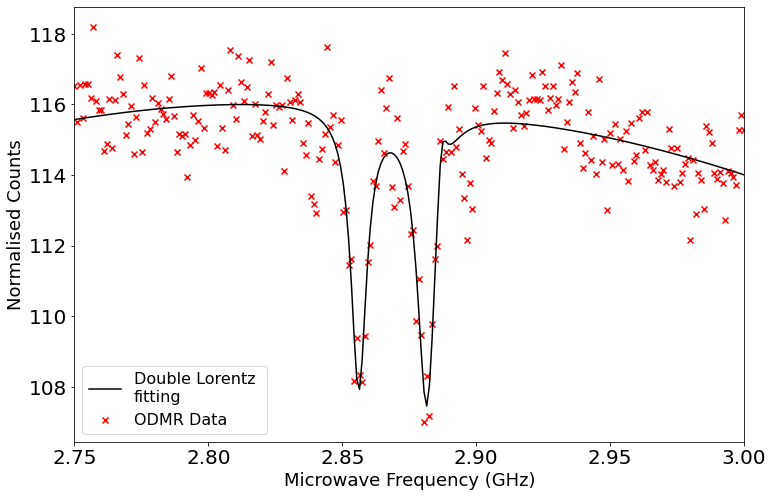

In [25]:
# The main script.
# Set the file and folder locations.
folder_location = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data Analysis\\Ryans Data (2018-2021)\\ODMR\\20201117\\Lock_in\\'
date = '20201117'
file_name = '20201117_NVScan_13_lock_in_averaged_results'

# Set the plot parameters
set_plot_params()

# Get the data from the file. 
data_frame = get_data(folder_location + file_name + '.dat')
freq = data_frame['Frequency (GHz)']
step = np.round(freq[2]-freq[1], 5)
intensity = data_frame.iloc[:,1]

# Normalise the dataset
#norm_mean_odmr = normalise_data(intensity)
norm_mean_odmr = intensity

# Plot the data
fig1, ax1 = scatter_plot(freq, intensity)

# find the freqeuncy points with the highest ODMR contrast
freq_mins, contrast, flourescent_baseline = get_init_params(norm_mean_odmr, freq)

# create the initial parameters for ODMR double lorentzian 
# line fitting
#init_params = [contrast[0], freq_mins[0], 0.001, -90, freq_mins[1], 0.01, flourescent_baseline]
init_params = [contrast[0], 2.835, 0.001, contrast[1], 2.86, 0.001, 
               contrast[0], 2.88, 0.001, contrast[1], 2.89, 0.001, flourescent_baseline]

# generate the optimised curve fit parameters. 
fitting_params, error_in_fit = optimised_lorentz_fit(freq, norm_mean_odmr, init_params)

# create the double lorentz fit array
if fitting_params[1] == 0:
    y_fit = 0
    fitted_contrast = [0, 0]
else:
    y_fit = quad_lorentz(freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], 
                     fitting_params[6], fitting_params[7], fitting_params[8],
                     fitting_params[9], fitting_params[10], fitting_params[11], fitting_params[12])

    # plot the fitting to ax1
    ax1 = plot_fitting(ax1, freq, y_fit)
    # get the r^2 value for the fitting 
    r_squared = get_r_squared(freq, norm_mean_odmr, y_fit)
    print(r_squared)
    fitted_contrast = get_fitting_contrast(fitting_params[1], fitting_params[4], fitting_params[7], fitting_params[10],
                                       freq, y_fit,  
                                       fitting_params[12], step)
    print(fitted_contrast)
    
    chi_squared = get_chi_squared(norm_mean_odmr/np.mean(norm_mean_odmr), y_fit/np.mean(y_fit))
    rms_error = get_RMS_error(norm_mean_odmr/np.mean(norm_mean_odmr), y_fit/np.mean(y_fit))
    
#save_data(date, file_name, nd, fitted_contrast, fitting_params, error_in_fit, r_squared, fig1, fig2)

In [19]:
print(step)

0.001
